## Semantic Role Labelling: data cleaning and analysis

This notebook cleans the raw results from `oecd_semantic_role_labeling.ipynb` and prepares the data for analysis using graph and network analysis tools such as NetworkX, Gephi and iGraph.

In [81]:
# plotly
# gensim
# pandas
# scipy
# jupyterlab
# matplotlib
# matplotlib-inline
# scikit-learn
# thefuzz
# cufflinks
# text-preprocessing
# nltk
# flair
# text_preprocessing

%pip freeze

absl-py==1.2.0
aiohttp==3.8.1
aiosignal==1.2.0
alembic==1.8.1
allennlp==2.4.0
allennlp-models==2.4.0
antlr4-python3-runtime==4.9.3
anyascii==0.3.1
anyio==3.6.1
AnyQt==0.1.0
appdirs==1.4.4
appnope==0.1.3
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asteroid-filterbanks==0.4.0
asttokens==2.0.5
async-timeout==4.0.2
attrs==21.4.0
audioread==2.1.9
autopage==0.5.1
Babel==2.10.1
backcall==0.2.0
backoff==1.11.1
backports.cached-property==1.0.2
base58==2.1.1
baycomp==1.0.2
beautifulsoup4==4.11.1
biopython==1.79
bleach==5.0.0
blis==0.7.8
boto3==1.24.31
botocore==1.27.31
Bottleneck==1.3.4
bpemb==0.3.3
CacheControl==0.12.11
cached-path==1.1.5
cachetools==5.2.0
catalogue==2.0.7
celluloid==0.2.0
certifi==2022.6.15
cffi==1.15.0
chardet==4.0.0
charset-normalizer==2.0.12
click==7.1.2
cliff==3.10.1
cloudpickle==2.1.0
cmaes==0.8.2
cmd2==2.4.2
colorama==0.4.5
colorlog==6.6.0
commonmark==0.9.1
configparser==5.2.0
conllu==4.4
contractions==0.1.72
cvr==0.2.0
cycler==0.11.0
cymem==2.0.6
dataclasses==0.6
d

In [11]:
import re
import json
import string
from pathlib import Path
import os
path = Path(os.getcwd())
data_dir = os.path.join(path.parents[0], "data-files")

### 1. Load the RAW SRL predictions

In [12]:
import pickle
import re
with open(os.path.join(data_dir, "srl_predictions_big.pkl"), 'rb') as f:
    srl_results = pickle.load(f)

In [13]:
def get_srl_tag_words(sentence):
    tokens = re.findall(r'\[(.*?)\]', sentence)
    verb = None
    arg0 = None 
    arg1 = None
    for token in tokens:
        if  token.startswith('V:'):
            verb = token.replace('V:','').strip()
        if  token.startswith('ARG0:'):
            arg0 = token.replace('ARG0:','').strip()
        if  token.startswith('ARG1:'):
            arg1 = token.replace('ARG1:','').strip()

    return verb, arg0, arg1

triples = set()
for i in range(0, len(srl_results)):
    for j in range(0, len(srl_results[i]["verbs"])):
        verb, arg0, arg1 = get_srl_tag_words(srl_results[i]["verbs"][j]['description'])
        if (verb is not None) and (arg0 is not None) and (arg1 is not None):
            triples.add((verb.strip(), arg0.strip(), arg1.strip()))

tripleslst = list(triples)

print(len(set(tripleslst)))

97852


In [14]:
print(tripleslst[0])

('have', 'developments in Rondônia', 'great impacts given the prominence in the region of hydropower , which complementarily supplies energy to the country')


### 2. Load the named entities dataset from the NER analysis

In [15]:
import pandas as pd

orgs_df = pd.read_csv(os.path.join(data_dir, "master-ner-results-singletokens.csv"))
orgs_df = orgs_df[orgs_df['entity_type'] == 'ORG'] # only organisaations

import unicodedata

def remove_accent(text):
    """
    Remove accent from text
    :param text: text to remove accent from
    :return: text without accent
    """
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')

unique_orgs = list(set(orgs_df['entity_as_single_token'].tolist()))
print(len(unique_orgs))
for org in unique_orgs:
    orgs_df['entity_as_single_token'] = orgs_df['entity_as_single_token'].replace(org, remove_accent(org))
    
unique_orgs = list(set(orgs_df['entity_as_single_token'].tolist()))
print(len(unique_orgs))

5967
5924


In [16]:
orgs_df.to_csv("test.csv", index=False)

### 3. Import stopwords and human-specified custom false positive entities

In [17]:
from nltk.corpus import stopwords

with open(os.path.join(data_dir, 'replace_stopwords_orgs.txt'), 'r') as f:
    other_stopwords = f.readlines()

other_stopwords2 = []
for item in other_stopwords:
    other_stopwords2.append(item.replace('\n','').replace('\r\n',''))

irrelevant_tokens = ['technology', 'project', 'region', 'agricultural', "'s", 'infrastructure', 'entity', 'state', 'on', 'world', 'working', 'management', 'water_management', 'council', 'task', 'team', 'water', 'climate_change', 'policy', 'covid-19', 'city', 'the', 'et', 'al.', 'x', 'pdf', 'yes', 'abbrev','also','fe',
                    'page', 'pp', 'p', 'er', 'doi', 'can', 'b', 'c', 'd', 'e',
                    'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'q', 'r', 's', 'herein', 'furthermore',
                    't', 'u', 'v', 'w', 'y', 'z', 'www', 'com', 'org', 'de', 'dx', 'th', 'ii', 'le', 'eur', 'gap', 'Bank', 'delta', 'aud']

stop_words = set(stopwords.words('english')).union(set(irrelevant_tokens))
stop_words = stop_words.union(set(other_stopwords2))


### 4. Clean SRL results: Pass 1 

In [18]:
from mhs import hitting_sets

def clean_srl_results(tripleslst):
    global stop_words
    global orgs_df
    
    highest_quality_results = set()
    overall_results = set()
    
    idx = 1
    total = len(list(set(tripleslst)))
    for item in list(set(tripleslst)):
        # if (idx % 2 == 0):
            # print(idx,"/",total, end=' ')
        idx+=1
        verb = item[0]
        arg0 = item[1]
        arg1 = item[2]
        arg0_tokens = arg0.split()
        arg1_tokens = arg1.split()
        if (len(arg0_tokens) == 1 and len(arg1_tokens) == 1):
            if (arg0_tokens[0].strip() not in stop_words) and (arg1_tokens[0].strip() not in stop_words):
                if (arg0_tokens[0].strip() in orgs_df['entity_as_single_token'].tolist()) and (arg1_tokens[0].strip() in orgs_df['entity_as_single_token'].tolist()):
                    highest_quality_results.add((verb, arg0_tokens[0].strip(), arg1_tokens[0].strip()))
                    overall_results.add((verb, arg0_tokens[0].strip(), arg1_tokens[0].strip()))
        else:
            if (len(arg0_tokens) > 1) and (len(arg1_tokens) > 1):
                relevant_tokens_only_0 = [w for w in arg0_tokens if not w in stop_words]
                relevant_tokens_only_0 = [w for w in relevant_tokens_only_0 if w in orgs_df['entity_as_single_token'].tolist()]
                valid_ent_0 = False
                for item in relevant_tokens_only_0:
                    if item in orgs_df['entity_as_single_token'].tolist():
                        valid_ent_0 = True
                        break
                        
                new_arg0 = ''
                if valid_ent_0:
                    new_arg0 = ','.join(list(set(relevant_tokens_only_0)))
                
                relevant_tokens_only_1 = [w for w in arg1_tokens if not w in stop_words]
                relevant_tokens_only_1 = [w for w in relevant_tokens_only_1 if w in orgs_df['entity_as_single_token'].tolist()]
                valid_ent_1 = False
                for item in relevant_tokens_only_1:
                    if item in orgs_df['entity_as_single_token'].tolist():
                        valid_ent_1 = True
                        break
                        
                new_arg1 = ''
                if valid_ent_1:
                    new_arg1 = ','.join(list(set(relevant_tokens_only_1)))
                    
                if (len(new_arg0) > 0 and len(new_arg1) > 0):
                    if (len(relevant_tokens_only_0) > 1) or (len(relevant_tokens_only_1) > 1):
                        #hitting sets
                        # if (len(relevant_tokens_only_0) > 6 or len(relevant_tokens_only_1) > 6):
                            # print('*', len(relevant_tokens_only_0), len(relevant_tokens_only_1))
                        hs = hitting_sets(set(relevant_tokens_only_0[:25]), set(relevant_tokens_only_1[:25]))
                        # print()
                        # print()
                        # print("original sets:", '\n', set(relevant_tokens_only_0), ',\n', set(relevant_tokens_only_1))
                        # print()
                        # print("hitting sets:")
                        new_hs = []
                        for hs_item in hs:
                            if len(hs_item) == 2:
                                new_hs.append(list(hs_item))
                                # print((verb, list(hs_item)[0], list(hs_item)[1]))
                                overall_results.add((verb, list(hs_item)[0], list(hs_item)[1]))
                        # print(list(new_hs))
                        # print()
                    else:   # print()
                        # print((verb, new_arg0, new_arg1))
                        overall_results.add((verb, new_arg0, new_arg1))
                    
            elif (len(arg0_tokens) > 1) and (len(arg1_tokens) == 1):
                relevant_tokens_only_0 = [w for w in arg0_tokens if not w in stop_words]
                relevant_tokens_only_0 = [w for w in relevant_tokens_only_0 if w in orgs_df['entity_as_single_token'].tolist()]
                valid_ent_0 = False
                for item in relevant_tokens_only_0:
                    if item in orgs_df['entity_as_single_token'].tolist():
                        valid_ent_0 = True
                        break
                        
                new_arg0 = ''
                if valid_ent_0:
                    new_arg0 = ','.join(list(set(relevant_tokens_only_0)))
                    
                if (len(new_arg0) > 0) and (arg1_tokens[0].strip() not in stop_words) and (arg1_tokens[0].strip() in orgs_df['entity_as_single_token'].tolist()):
                    if len(relevant_tokens_only_0) > 1:
                        #hitting sets
                        # if (len(relevant_tokens_only_0) > 6):
                            # print('*', len(relevant_tokens_only_0))
                        
                        hs = hitting_sets(set(relevant_tokens_only_0[:50]), set({arg1_tokens[0].strip()}))
                        # print()
                        # print()
                        # print("original sets:", '\n', set(relevant_tokens_only_0), ',\n', set({arg1_tokens[0].strip()}))
                        # print()
                        # print("hitting sets:")
                        new_hs = []
                        for hs_item in hs:
                            if len(hs_item) == 2:
                                new_hs.append(list(hs_item))
                                # print((verb, list(hs_item)[0], list(hs_item)[1]))
                                overall_results.add((verb, list(hs_item)[0], list(hs_item)[1]))
                        # print(list(new_hs))
                        # print()
                        # print()
                    else:
                        # print((verb, new_arg0, arg1_tokens[0].strip()))
                        overall_results.add((verb, new_arg0, arg1_tokens[0].strip()))
                    
            elif (len(arg1_tokens) > 1) and (len(arg0_tokens) == 1):
                relevant_tokens_only_1 = [w for w in arg1_tokens if not w in stop_words]
                relevant_tokens_only_1 = [w for w in relevant_tokens_only_1 if w in orgs_df['entity_as_single_token'].tolist()]
                valid_ent_1 = False
                for item in relevant_tokens_only_1:
                    if item in orgs_df['entity_as_single_token'].tolist():
                        valid_ent_1 = True
                        break
                        
                new_arg1 = ''
                if valid_ent_1:
                    
                    new_arg1 = ','.join(list(set(relevant_tokens_only_1)))
                    
                if (len(new_arg1) > 0) and (arg0_tokens[0].strip() not in stop_words) and (arg0_tokens[0].strip() in orgs_df['entity_as_single_token'].tolist()):
                    if len(relevant_tokens_only_1) > 1:
                        #hitting sets
                        # if (len(relevant_tokens_only_1) > 6):
                            # print('*', len(relevant_tokens_only_1))
                        hs = hitting_sets(set({arg0_tokens[0].strip()}), set(relevant_tokens_only_1[:50]))
                        # print()
                        # print()
                        # print("original sets:", '\n', set({arg0_tokens[0].strip()}), ',\n', set(relevant_tokens_only_1))
                        # print()
                        # print("hitting sets:")
                        new_hs = []
                        for hs_item in hs:
                            if len(hs_item) == 2:
                                new_hs.append(list(hs_item))
                                # print((verb, list(hs_item)[0], list(hs_item)[1]))
                                overall_results.add((verb, list(hs_item)[0], list(hs_item)[1]))

                        # print(list(new_hs))
                        # print()
                        # print()
                    else:
                        # print((verb, arg0_tokens[0].strip(), new_arg1))
                        overall_results.add((verb, arg0_tokens[0].strip(), new_arg1))
        # print()
    return list(highest_quality_results), list(overall_results)
                
        

In [19]:
new_hq_res, overall_res = clean_srl_results(tripleslst)

In [20]:
print(len(set(new_hq_res)))
print(len(set(overall_res)))

3
952


### 5. Save Pass 1 cleaning results to file

In [21]:
import pickle
with open(os.path.join(data_dir, 'srl_predictions_cleaned_singletoken_entities_only.pkl'), 'wb') as f:
    pickle.dump(new_hq_res, f)
    
with open(os.path.join(data_dir, 'srl_predictions_cleaned_pass1.pkl'), 'wb') as f:
    pickle.dump(overall_res, f)

### 6. Clean SRL results: Pass 2 

In [22]:
with open(os.path.join(data_dir, 'replace_stopwords_orgs.txt'), 'r') as f:
    other_stopwords = f.readlines()

other_stopwords2 = []
for item in other_stopwords:
    other_stopwords2.append(item.replace('\n','').replace('\r\n',''))
    
other_stopwords2 = list(set(other_stopwords2))
cleaned_pass2_hq = []
cleaned_pass2_overall = []

replacements = {
    "solution_water.org" : "water.org",
    "us" : "united_states",
    "eu" : "european_union",
    "un" : "united_nations",
    "ec" : "european_commission",
    "ea" : "environmental_agency",
    "environment_agency" : "environmental_agency",
    "eap_task_force" : "oecd_eap_task_force",
    "wb" : "world_bank"
}

def replace_all(text, dic):
    for i, j in dic.items():
        if text.strip() == i:
            text = text.replace(text, j)
    return text

def clean_srl_list_pass2(lst, stopwords):
    cleaned_lst = []
    for item in lst:
        verb = item[0]
        arg0 = item[1]
        arg1 = item[2]

        if (arg0 not in stopwords) and (arg1 not in stopwords):
            if arg0.startswith('the_'):
                arg0 = arg0.replace(arg0[:4], '')

            if arg1.startswith('the_'):
                arg1 = arg1.replace(arg1[:4], '')

            if '_' in arg0:
                arg0tokens = arg0.split('_')
                # print('arg0:', arg0tokens)
                arg0relevant_tokens = []
                for token in arg0tokens:
                    new_token = replace_all(token, replacements)
                    arg0relevant_tokens.append(new_token)
                # print('arg0rel:', arg0relevant_tokens)
                arg0 = '_'.join(arg0relevant_tokens)
            else:
                arg0 = replace_all(arg0, replacements)
                
            if '_' in arg1:
                arg1tokens = arg1.split('_')
                # print('arg1:', arg1tokens)
                arg1relevant_tokens = []
                for token2 in arg1tokens:
                    new_token2 = replace_all(token2, replacements)
                    arg1relevant_tokens.append(new_token2)
                # print('arg1rel:', arg1relevant_tokens)
                arg1 = '_'.join(arg1relevant_tokens)
            else:
                arg1 = replace_all(arg1, replacements)
        
        if (arg0 not in stopwords) and (arg1 not in stopwords):
            cleaned_lst.append((verb, arg0, arg1))
        
    return list(set(cleaned_lst))

cleaned_pass2_hq = clean_srl_list_pass2(new_hq_res, other_stopwords2)
cleaned_pass2_overall = clean_srl_list_pass2(overall_res, other_stopwords2)

### 7. Convert cleaned SRL data to network analysis format

In [23]:
def convert_data_to_networkx_format(data):
    edge_data = []
    edge_data_with_labels = {}
    
    for item in data:
        edge_data.append([item[1], item[2]])
        
    for edge in edge_data:
        edge_data_with_labels[(''+edge[0]+'', ''+edge[1]+'')] = []
        
    for item in data:
        edge_data_with_labels[(''+item[1]+'', ''+item[2]+'')].append(item[0])
    
    for key in edge_data_with_labels:
        edge_data_with_labels[key] = ', '.join(list(set(edge_data_with_labels[key])))
        
    return edge_data, edge_data_with_labels
    
single_token_graph_edges, single_token_graph_edges_with_labels = convert_data_to_networkx_format(cleaned_pass2_hq)
full_graph_edges, full_graph_edges_with_labels = convert_data_to_networkx_format(cleaned_pass2_overall)


### 8. Save cleaned SRL results to file 

To import into Gephi.

In [40]:
import csv

header = ['verb', 'source', 'target']

# some additional false positive organizations to remove

fps = ['water_governance',
'water_services',
'project_management_unit',
'water_framework_directive',
'administrations',
'administration',
'welf',
'regulators',
'domestic_agriculture_industry',
'oecd_principles',
'oecd_countries',
'region_administrations',
'climate_change_adaptation',
'finances',
'sustainable_development',
'city_council',
'city_councils',
'regulator',
'regional_council',
'regional_environmental_offices',
'regional_environmental_office',
'ecosystem_services',
'finance',
'region_administration',
'technical_secretariats',
'a_partnership_council',
'a_partnership_councils',
'a_national_water_council',
'user',
'users',
'infrastructures']

with open(os.path.join(data_dir, 'single_token_actors_data.csv'), 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)

    for item in cleaned_pass2_hq:
        if (item[1] not in fps) and (item[2] not in fps):
            rowdata = [item[0], item[1], item[2]]        
            writer.writerow(rowdata)
        
with open(os.path.join(data_dir, 'single_token_actors_data_edgesonly.csv'), 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header[-2:])

    for item in cleaned_pass2_hq:
        if (item[1] not in fps) and (item[2] not in fps):
            rowdata = [item[1], item[2]]        
            writer.writerow(rowdata)
    
with open(os.path.join(data_dir, 'full_actors_data.csv'), 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)

    for item in cleaned_pass2_overall:
        if (item[1] not in fps) and (item[2] not in fps):
            rowdata = [item[0], item[1], item[2]]        
            writer.writerow(rowdata)
        
with open(os.path.join(data_dir, 'full_actors_data_edgesonly.csv'), 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header[-2:])

    for item in cleaned_pass2_overall:
        if (item[1] not in fps) and (item[2] not in fps):
            rowdata = [item[1], item[2]]        
            writer.writerow(rowdata)

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

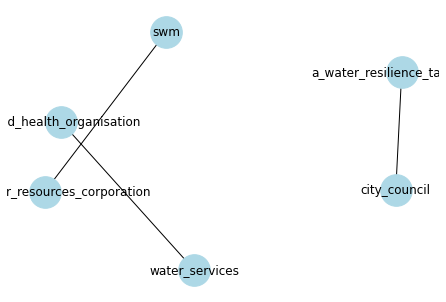

In [26]:
edges = single_token_graph_edges
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, k=2, scale=1, iterations=50)

plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=1000, node_color='lightblue', alpha=1,
    labels={node: node for node in G.nodes()}
)
# nx.draw_networkx_edge_labels(
#     G, pos,
#     # edge_labels={('A', 'B'): 'AB', ('B', 'C'): 'BC', ('B', 'D'): 'BD'},
#     # edge_labels=single_token_graph_edges_with_labels,
#     font_color='red'
# )
plt.axis('off')
plt.show()